<a href="https://colab.research.google.com/github/ribalchusy/machine-learning/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №5: Методы, основанные на деревьях решений. Регрессионные деревья. Деревья классификации. Случайный лес. Бустинг.

В практических примерах ниже показано:

*   как делать перекодировку признаков в номинальной и порядковой шкалах
*   как вырастить дерево и сделать обрезку его ветвей
*   как настроить модель бэггинга
*   как вырастить случайный лес
*   как настроить модель бустинга на деревьях решений
*   как подбирать настроенные параметры моделей методом сеточного поиска Точность всех моделей оценивается методом перекрёстной проверки по 5 блокам.

# Загружаем пакеты

In [ ]:
import sklearn
print(sklearn.__version__)

1.2.2


In [ ]:
# загрузка пакетов: инструменты --------------------------------------------
# работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# загрузка файлов по URL
import urllib
# проверка существования файла на диске
from pathlib import Path
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency
# для таймера
import time
# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets
# загрузка пакетов: модели -------------------------------------------------
# дерево классификации
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier
# сводка по точности классификации
from sklearn.metrics import classification_report

In [ ]:
# константы
# ядро для генератора случайных чисел
my_seed = 15
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков:
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру

<ipython-input-3-5fbb62c968c8>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-whitegrid')


In [ ]:
# функция форматирования результатов с использованием Markdown
def printmd(string):
 display(Markdown(string))

# функции для попарной конкатенации элементов двух списков
concat_func_md = lambda x, y: '`' + str(x) + "`:&ensp;&ensp;&ensp;&ensp;" + str(y)
concat_func = lambda x, y: str(x) + ' ' * 4 + str(y)
# функция, которая строит график важности признаков в модели случайного леса
# источник: https://www.analyseup.com/learn-python-for-data-science/python-rand
def plot_feature_importance(importance, names, model_type):
 #Create arrays from feature importance and feature names
 feature_importance = np.array(importance)
 feature_names = np.array(names)
 #Create a DataFrame using a Dictionary
 data={'feature_names':feature_names,'feature_importance':feature_importance}
 fi_df = pd.DataFrame(data)
 #Sort the DataFrame in order decreasing feature importance
 fi_df.sort_values(by=['feature_importance'], ascending=False,
 inplace=True)
 #Define size of bar plot
 plt.figure(figsize=(10,8))
 #Plot Searborn bar chart
 sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
 #Add chart labels
 plt.title('Важность признаков в модели: ' + model_type)
 plt.xlabel('Важность признака')
 plt.ylabel('')

# Загружаем данные:

In [ ]:
# загружаем таблицу и превращаем её во фрейм
fileURL = 'default_of_credit_card_clients.csv'
DF_all = pd.read_csv(fileURL)
# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (30000, 24)


# Откладываем 15% наблюдений для прогноза

*   оставляем только нужные перменные


In [ ]:
# оставляем в наборе данных только то, что нужно
DF_all = DF_all[['Y' , 'LIMIT_BAL' , 'SEX' , 'EDUCATION' , 'MARRIAGE' , 'AGE' , 'PAY_0' , 'PAY_2' , 'PAY_3' ,'BILL_AMT1' , 'BILL_AMT2' , 'BILL_AMT3' , 'PAY_AMT1' ,  'PAY_AMT2'  , 'PAY_AMT3']]
DF_all.head(5)

,Y,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,PAY_AMT1,PAY_AMT2,PAY_AMT3
0,1,20000,2,2,1,24,2,2,-1,3913,3102,689,0,689,0
1,1,120000,2,2,2,26,-1,2,0,2682,1725,2682,0,1000,1000
2,0,90000,2,2,2,34,0,0,0,29239,14027,13559,1518,1500,1000
3,0,50000,2,2,1,37,0,0,0,46990,48233,49291,2000,2019,1200
4,0,50000,1,2,1,57,-1,0,-1,8617,5670,35835,2000,36681,10000


In [ ]:
# наблюдения для моделирования
DF = DF_all.sample(frac = 0.85, random_state = my_seed)
# отложенные наблюдения
DF_predict = DF_all.drop(DF.index)

In [ ]:
# типы столбцов фрейма
DF.dtypes

Y            int64
LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
dtype: object

In [ ]:
# считаем пропуски в каждом столбце
DF.isna().sum()

Y            0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
dtype: int64

In [ ]:
# метки классов
DF.Y.unique()

array([1, 0])

# Модель дерева

В этом разделе построим:

*   дерево классификации
*   дерево классификации с обрезкой ветвей

# Дерево на всех признаках
Построим модель и выведем изображение дерева в виде текста.

In [ ]:
# выращиваем дерево на всех объясняющих
X = DF.drop(['Y'], axis=1)
y = DF['Y']
# классификатор
cls_one_tree = DecisionTreeClassifier(criterion='entropy',
 random_state=my_seed)
tree_full = cls_one_tree.fit(X, y)
# выводим количество листьев (количество узлов)
tree_full.get_n_leaves()

4207

In [ ]:
# глубина дерева: количество узлов от корня до листа
# в самой длинной ветви
tree_full.get_depth()

49

Очевидно, дерево получилось слишком большое для отображения в текстовом формате. Графическая визуализация тоже не поможет в данном случае. Посчитаем показатели точности с перекрёстной проверкой.

In [ ]:
# будем сохранять точность моделей в один массив:
score = list()
score_models = list()
# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=cls_one_tree, X=X, y=y, cv=5,
 scoring='accuracy')
# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('one_tree')
print('Acc с перекрёстной проверкой',
 '\nдля модели', score_models[0], ':', score[0])

Acc с перекрёстной проверкой 
для модели one_tree : 0.722


# Дерево с обрезкой ветвей
Подберём оптимальное количество ветвей, которое максимизирует , для экономии времени рассчитанный методом проверочной выборки.

In [ ]:
# рассчитываем параметры alpha для эффективных вариантов обрезки ветвей
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('Всего значений alpha:', len(ccp_alphas))
print('Энтропия листьев для первых 5 значений alpha:', impurities[:5])

Всего значений alpha: 1728
Энтропия листьев для первых 5 значений alpha: [0.00150058 0.00153409 0.00158292 0.00161253 0.00164213]


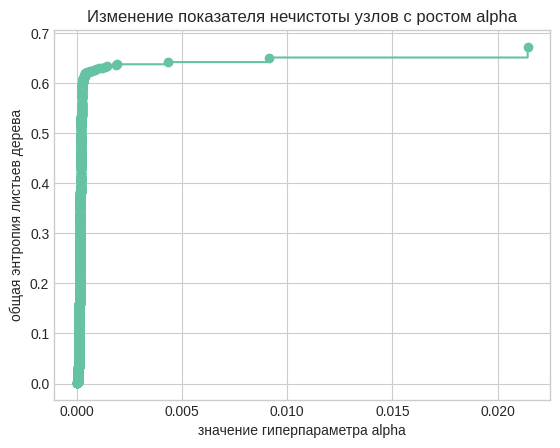

In [ ]:
# изображаем на графике
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("значение гиперпараметра alpha")
plt.ylabel("общая энтропия листьев дерева")
plt.title("Изменение показателя нечистоты узлов с ростом alpha")
plt.show()

In [ ]:
# обучающая и тестовая выборки, чтобы сэкономить время
X_train, X_test, y_train, y_test = train_test_split(X, y,
 random_state=my_seed)
# модели
clfs = list()
# таймер
tic = time.perf_counter()
# цикл по значениям alpha
for ccp_alpha in ccp_alphas:
 clf = DecisionTreeClassifier(random_state=my_seed, ccp_alpha=ccp_alpha)
 clf.fit(X_train, y_train)
 clfs.append(clf)
# таймер
toc = time.perf_counter()
print(f"Расчёты по обрезке дерева заняли {toc - tic:0.2f} секунд")

Расчёты по обрезке дерева заняли 604.77 секунд


In [ ]:
# извлекаем характеристики глубины и точности
# таймер
tic = time.perf_counter()
node_counts = [clf.tree_.node_count for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
# таймер
toc = time.perf_counter()
print(f"Расчёты показателей точности заняли {toc - tic:0.2f} секунд")

Расчёты показателей точности заняли 24.42 секунд


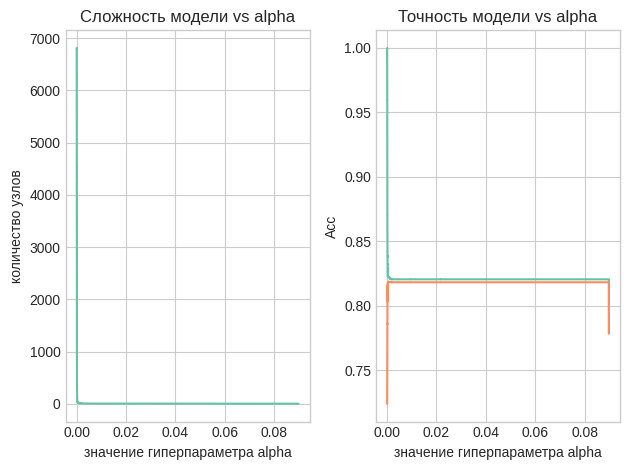

In [ ]:
# изображаем на графике
fig, ax = plt.subplots(1, 2)
# график глубины дерева
ax[0].plot(ccp_alphas, node_counts, marker=',', drawstyle="steps-post")
ax[0].set_xlabel("значение гиперпараметра alpha")
ax[0].set_ylabel("количество узлов")
ax[0].set_title("Сложность модели vs alpha")
# график точности
ax[1].plot(ccp_alphas, train_scores, marker=',', label='train',
 drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores, marker=',', label='test',
 drawstyle="steps-post")
ax[1].set_xlabel("значение гиперпараметра alpha")
ax[1].set_ylabel("Acc")
ax[1].set_title("Точность модели vs alpha")
fig.tight_layout()

Находим оптимальный размер дерева по максимуму на тестовой выборке.

In [ ]:
# оптимальное количество узлов
opt_nodes_num = node_counts[test_scores.index(max(test_scores))]
# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=clfs[opt_nodes_num], X=X, y=y, cv=5,
 scoring='accuracy')
# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('pruned_tree')
print('Оптимальное количество узлов:', opt_nodes_num,
 '\nсоответствующая Acc на тестовой:', np.around(max(test_scores), 3),
 '\n\nAcc с перекрёстной проверкой',
 '\nдля модели', score_models[1], ':', score[1])

Оптимальное количество узлов: 21 
соответствующая Acc на тестовой: 0.819 

Acc с перекрёстной проверкой 
для модели pruned_tree : 0.737


Посмотрим на характеристики глубины и сложности построенного дерева с обрезкой ветвей.

In [ ]:
# выводим количество листьев (количество узлов)
clfs[opt_nodes_num].get_n_leaves()

2748

In [ ]:
# глубина дерева: количество узлов от корня до листа
# в самой длинной ветви
clfs[opt_nodes_num].get_depth()

38

# Бустинг
Подберём сеточным поиском настроечные параметры модели:

B число деревьев


*   λ – скорость обучения
*   d – глубина взаимодействия предикторов

In [ ]:
# разбиения для перекрёстной проверки
kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)
# обучаем модель с параметрами по умолчанию
clf_tst = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
 max_depth=1, random_state=my_seed)
cv = cross_val_score(clf_tst, X, y, cv=kfold, scoring='accuracy')
np.around(np.mean(cv), 3)

0.819

In [26]:
# настроим параметры бустинга с помощью сеточного поиска
param_grid = {'n_estimators' : [10, 20, 30, 40, 50],
 'learning_rate' : np.linspace(start=0.01, stop=0.25, num=15),
 'max_depth' : [1, 2]}
# таймер
tic = time.perf_counter()
clf = GridSearchCV(GradientBoostingClassifier(),
 param_grid, scoring='accuracy', cv=kfold)
boost_tree = clf.fit(X, y)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 701.24 секунд


In [27]:
# точность лучшей модели
np.around(boost_tree.best_score_, 3)

0.822

In [28]:
# параметры лучшей модели
print('n_estimators:',
 boost_tree.best_estimator_.get_params()['n_estimators'],
 '\nlearning_rate:',
 boost_tree.best_estimator_.get_params()['learning_rate'],
 '\nmax_depth:',
 boost_tree.best_estimator_.get_params()['max_depth'])

n_estimators: 40 
learning_rate: 0.14714285714285716 
max_depth: 2


In [30]:
# записываем точность
score.append(np.around(boost_tree.best_score_, 3))
score_models.append('boost_tree_GS')
print(score_models[3], ':', score[3])

boost_tree_GS : 0.822


# Прогноз на отложенные наблюдения по лучшей модели
Ещё раз посмотрим на точность построенных моделей.

In [31]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,one_tree,0.722
1,pruned_tree,0.737
2,boost_tree_GS,0.822
3,boost_tree_GS,0.822


Все модели показывают среднюю точность по показателю , при этом самой точной оказывается модель случайного леса. Сделаем прогноз на отложенные наблюдения.

In [35]:
# данные для прогноза
X_pred = DF_predict.drop(['Y'], axis=1)
# строим прогноз
y_hat = boost_tree.best_estimator_.predict(X_pred)
# характеристики точности
print(classification_report(DF_predict['Y'], y_hat))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      3503
           1       0.69      0.33      0.44       997

    accuracy                           0.82      4500
   macro avg       0.76      0.64      0.67      4500
weighted avg       0.80      0.82      0.79      4500

